In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow_addons as tfa


c:\Users\gyova\Documents\Projetos\Model-dectation-fake-news\ven\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
df = pd.read_csv('../data/pre-processed.csv')
df = df.drop(columns=['index'])
df.isnull().any()

label                False
preprocessed_news    False
dtype: bool

In [3]:
df['label'] = df.apply(lambda row: 1 if row.label == 'fake' else 0, axis=1)
X = df.drop(['label'], axis = 1)
Y = df['label']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5, stratify=Y)

X_train = X_train['preprocessed_news'].apply(lambda x: x.lower())
X_test = X_test['preprocessed_news'].apply(lambda x: x.lower())

train_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
train_tokenizer.fit_on_texts(X_train.values)
train_word_index = train_tokenizer.word_index


In [5]:
train_sequences = train_tokenizer.texts_to_sequences(X_train)
vocab_length = len(train_word_index) + 1
test_sequences = train_tokenizer.texts_to_sequences(X_test)

print(f'Vocab length {vocab_length}, Train sequences {len(train_sequences)}, Test sequences {len(test_sequences)} ')

Vocab length 72906, Train sequences 5760, Test sequences 1440 


In [6]:
maxlen=40
train_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, padding='post', maxlen=maxlen, truncating='post')
test_padded_seqeunces = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, padding='post', maxlen=maxlen, truncating='post')

In [7]:
embedding_dim = 6
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
    tf.keras.layers.GRU(60, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(30, return_sequences=True),
    tf.keras.layers.SimpleRNN(3, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 6)             437436    
                                                                 
 gru (GRU)                   (None, 40, 60)            12240     
                                                                 
 lstm (LSTM)                 (None, 40, 30)            10920     
                                                                 
 simple_rnn (SimpleRNN)      (None, 3)                 102       
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 24)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [8]:

history = model.fit(train_padded_seqeunces, y_train, epochs=50, batch_size=50, validation_data=[test_padded_seqeunces, y_test])


Epoch 1/50
116/116 [==============================] - 8s 36ms/step - loss: 0.6808 - accuracy: 0.5519 - val_loss: 0.5490 - val_accuracy: 0.7715
Epoch 2/50
 79/116 [===================>..........] - ETA: 1s - loss: 0.4077 - accuracy: 0.8428

KeyboardInterrupt: 

45/45 [==============================] - 0s 6ms/step


<Axes: >

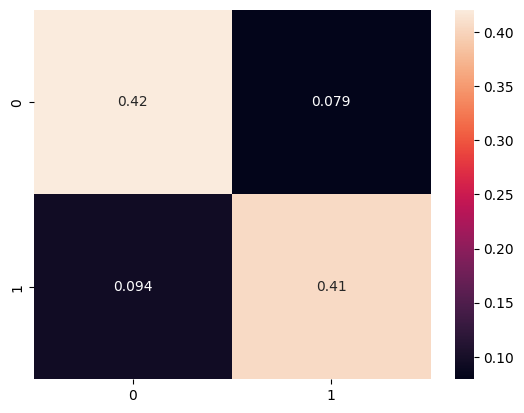

In [ ]:
from sklearn.metrics import confusion_matrix
y_train_pred = model.predict(test_padded_seqeunces)
y_train_pred = (y_train_pred > 0.75)
cm = confusion_matrix(y_test, y_train_pred, normalize='all')
sns.heatmap(cm, annot=True)

# Visualize the results:

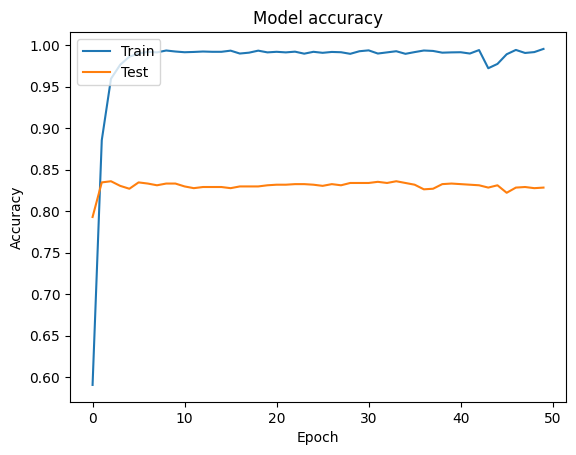

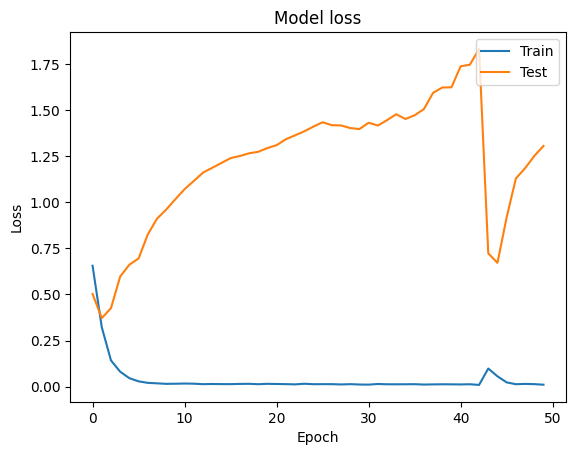

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

Salva modelo

Model Testing

In [ ]:
   
news = 'facebook dilma usa rede social reclamar restricoes voos presidente afastada reclamou restricoes uso avioes fab impostas governo michel temer dialogos internautas facebook hoje dilma disse despedir porque precisava correr aeroporto devido restricoes impostas deslocamento governo golpista determinacao casa civil dilma so pode usar veiculos viagens brasilia porto alegre dilma tambem gabou sobre olimpiadas jogos sao brasil tambem verdade governo realizou todos investimentos necessarios prontos fazer grande evento escreveu'



def output_lable(n):
    if n == 1:
        return "Fake News"
    elif n == 0:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_x_test = new_def_test["text"]
    new_xv_test = train_tokenizer.texts_to_sequences(new_x_test)
    new_xv_test = tf.keras.preprocessing.sequence.pad_sequences(new_xv_test, padding='post', maxlen=maxlen, truncating='post')

    pred_news = model.predict(new_xv_test)
    return print("\n\nSimpleRNN Prediction: {}".format(pred_news[0]))                  

manual_testing(valida_text)

1/1 [==============================] - 0s 29ms/step


SimpleRNN Prediction: [0.9998502]


In [ ]:
inv_index = {v: k for k, v in train_tokenizer.word_index.items()}
for w in test_sequences[3]:
    x = inv_index.get(w)
    print(x,end = ' ')


In [ ]:
from nltk.corpus import stopwords
import string

# clearly more cleaning is needed here, but really I should get a better tokenizer
stop = stopwords.words('portuguese') 
cleanwords = [i for i in words if i not in stop and i.isalpha() and len(i) > 2]
cleanwords

NameError: name 'words' is not defined